# Probability Callibration Study
Small study of probability calibration for classifier used with
the propensity score. See
[sklearn documentation](https://scikit-learn.org/stable/modules/calibration.html)
for more. 

Also, a discussion of what this means for causal estimators and the respective frameworks can be found [in this discussion.](https://github.com/uber/causalml/issues/82) 

In [1]:
# Setup and import everything needed
import numpy as np
from pygam import LogisticGAM, s

np.random.seed(0)

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

from causalml.propensity import ElasticNetPropensityModel


In [2]:

X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=2)

def calibrate(ps, treatment):
    """Calibrate propensity scores with logistic GAM.
    Ref: https://pygam.readthedocs.io/en/latest/api/logisticgam.html
    Args:
        ps (numpy.array): a propensity score vector
        treatment (numpy.array): a binary treatment vector (0: control, 1: treated)
    Returns:
        (numpy.array): a calibrated propensity score vector
    """

    gam = LogisticGAM(s(0)).fit(ps, treatment)

    return gam.predict_proba(ps)

train_samples = 1000  # Samples used for training the models

X_train = X[:train_samples]
X_test = X[train_samples:]
y_train = y[:train_samples]
y_test = y[train_samples:]

# Create classifiers
lr = LogisticRegression(solver='lbfgs')
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier(n_estimators=100)
en = ElasticNetPropensityModel(n_fold=5)
post = None
cv = CalibratedClassifierCV(RandomForestClassifier(), method='isotonic')


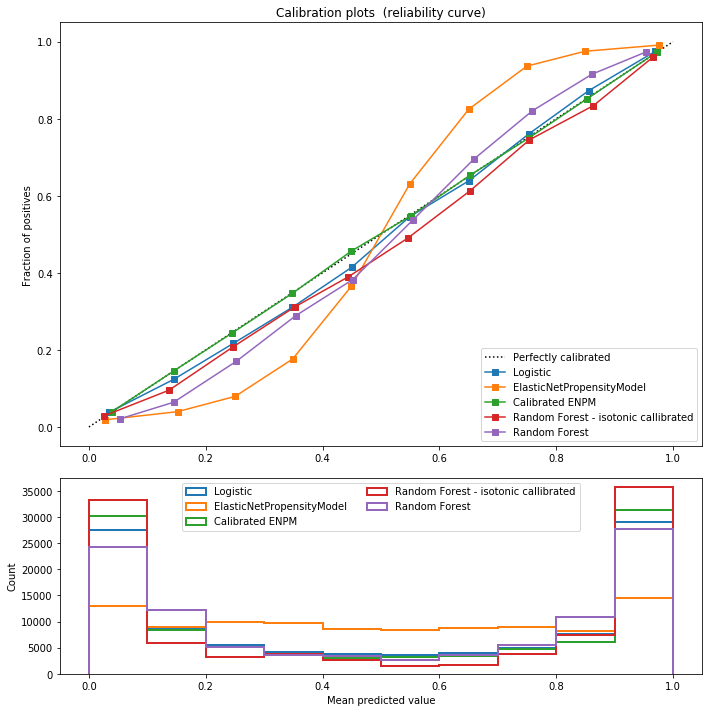

In [3]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  # (gnb, 'Naive Bayes'),
                  # (svc, 'Support Vector Classification'),
                  (en, 'ElasticNetPropensityModel'),
                  (post, 'Calibrated ENPM'),
                  (cv, 'Random Forest - isotonic callibrated'),
                  (rfc, 'Random Forest')]:
    if not name is 'Calibrated ENPM':
        clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    elif isinstance(clf, ElasticNetPropensityModel):
        prob_pos = clf.predict(X_test)
    elif name is 'Calibrated ENPM':
        prob_pos = calibrate(en.predict(X_test), y_test)
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)


ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()